In [1]:
library(GenomicAlignments)
library(ggbio)
library(GenomicRanges)
library(ggplot2)
library(gridExtra)
library(data.table)

Warning message:
“package ‘GenomicAlignments’ was built under R version 4.0.3”
Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


In [2]:
#load annotation file, make to gRanges for plots 

locs=read.csv("/Users/amyvandiver/Box/Nanopore/mitogenes.csv")
gr= GRanges(seqnames=rep("M",nrow(locs)), IRanges(start=locs$Start,end=locs$End),strand=rep('*',nrow(locs)),name=locs$Name,type=locs$Type,complex=locs$Complex)
gr$names1=gr$name
gr$names1[which(gr$type=="tRNA")]=NA
gr$names1[which(gr$type=="D-Loop")]=NA
gr$names1[which(gr$name=="ATP8")]=NA
gr$names1[which(gr$name=="ATP6")]="ATP8-ATP6"

seqlengths(gr)<-("M"=max(end(gr)))

In [3]:
setwd("/Users/amyvandiver/Box/Nanopore/Timp_data/")

In [4]:
#make annotation file to fill in stats later
anno=data.frame(name=c("190226_UCLA_HD1","190314_UCLA_young","210506_y3_UCLA",
        "190314_UCLA_old","210326_old3_UCLA_run1","210420_o3_run2_UCLA","210506_o4_UCLA","210528_UCLA_o4_run2"),
                sample=c("Y1","Y2","Y3","O1","O2","O2","O3","O3"),age=c("31","20","26","64","81","81","86","86"))
anno1=data.frame(name=c("190226_UCLA_HD1","190314_UCLA_young","210506_y3_UCLA",
        "190314_UCLA_old","old3_UCLA_merge","old4_UCLA_merge"),
                sample=c("Y1","Y2","Y3","O1","O2","O3"),age=c("31","20","26","64","81","86"))
anno$chrMalign=NA
                                                                                               

In [8]:
#define mode function to get summary stats
getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

In [19]:
#loop through each bam and get summary stats for anno table
anno$chrMcount=rep(NA,nrow(anno))
anno$chrMmean=rep(NA,nrow(anno))
anno$chrMmedian=rep(NA,nrow(anno))
anno$chrMmode=rep(NA,nrow(anno))
anno$large=rep(NA,nrow(anno))

for (i in 1:nrow(anno)){
    bam=paste0("Muscle/bam/",anno$name[i],".rot.bam")
    param=ScanBamParam(flag=scanBamFlag(isDuplicate=FALSE,isSecondaryAlignment=FALSE),what=c("qual","flag"))
    dat=readGAlignments(bam,use.names=TRUE,param=param)
    datM=dat[which(seqnames(dat)=="chrM_rot")]
    anno$chrMcount[i]=length(datM)
    anno$chrMmean[i]=mean(qwidth(datM))
    anno$chrMmedian[i]=median(qwidth(datM))
    anno$chrMmode[i]=getmode(qwidth(datM))
    anno$large[i]=length(which(qwidth(datM)>15000))/length(datM)
}

anno

name,sample,age,chrMalign,chrMcount,chrMmean,chrMmedian,chrMmode,large
<chr>,<chr>,<chr>,<lgl>,<int>,<dbl>,<dbl>,<int>,<dbl>
190226_UCLA_HD1,Y1,31,NA,53957,3874.019,2823,249,0.02290713
190314_UCLA_young,Y2,20,NA,145127,11230.182,15520,16472,0.51570004
210506_y3_UCLA,Y3,26,NA,14823,6839.948,5333,16310,0.14227889
190314_UCLA_old,O1,64,NA,78691,12649.737,16209,16384,0.64673215
210326_old3_UCLA_run1,O2,81,NA,75858,6400.521,4769,1503,0.12564265
210420_o3_run2_UCLA,O2,81,NA,52396,6783.835,5229,16451,0.14235820
210506_o4_UCLA,O3,86,NA,4071,8721.106,7879,16412,0.28592483
210528_UCLA_o4_run2,O3,86,NA,26580,9380.071,9101,16460,0.32174567


In [25]:
#loop through each bam (with merged bams) and count deletions >100 bp in the CIGARS
dels=data.frame(sample=NA,read=NA,start=NA,len=NA)

for (i in 1:nrow(anno)){
    bam=paste0("Muscle/bam/",anno$name[i],".rot.bam")
    dat=readGAlignments(bam,use.names=TRUE)
    datM=dat[which(seqnames(dat)=="chrM_rot")]
    
    st=rep(NA,length(datM))
    len=rep(NA,length(datM))
    for (j in 1:length(datM)){
        tab=data.frame(letter=unlist(explodeCigarOps(cigar(datM)[j])),
                   number=as.numeric(unlist(explodeCigarOpLengths(cigar(datM)[j]))))
    
        if (length(which(tab$letter=="D"&tab$number>100))>0){
            idx=which(tab$letter=="D"&tab$number>100)
            for (k in 1:length(idx)){
                p=tab[1:idx[k]-1,]
                del1=data.frame(sample=anno$sample[i],read=names(datM)[j],
                      start=start(datM)[j]+sum((p$number[which(p$letter%in%c("M","D"))])),
                        len=tab$number[idx[k]])
                dels=rbind(dels,del1)   
        }
        }
 
}
       
    }
dels=dels[-1,]
write.csv(dels,paste0("Muscle/deletions/all_deletions_100bp.csv"))

In [105]:
Dels=read.csv("Muscle/deletions/all_deletions_100bp.csv")


In [106]:
#Make age category, subset >2kbp
Dels$cat=substr(Dels$sample,1,1)
Dels$end=Dels$start+Dels$len

Dels1=Dels[which(Dels$len>2000),]

In [107]:
#count deletions of each size for each sample 

names=c("Y1","Y2","Y3","O1","O2","O3")
sum=data.frame(names)
sum$short=rep(NA,length(names))
sum$long=rep(NA,length(names))


for (i in 1:length(names)){
    query=names[i]
    sum$short[i]=nrow(Dels[which(Dels$len<2000 & Dels$sample==query),])
    sum$long[i]=nrow(Dels[which(Dels$len>2000 & Dels$sample==query),])

}

sum
write.csv(sum,"Muscle/deletions/Deletion_summary.csv")

names,short,long
<chr>,<int>,<int>
Y1,389,4
Y2,2168,19
Y3,173,7
O1,1656,129
O2,878,89
O3,276,100


In [108]:
#How many of deletions >2000 are in old samples? 
nrow(Dels[which(Dels$len>2000),])
nrow(Dels[which(Dels$len>2000 & Dels$cat=="O"),])
nrow(Dels[which(Dels$len>2000 & Dels$cat=="O"),])/nrow(Dels[which(Dels$len>2000),])

[1] 348

[1] 318

[1] 0.9137931

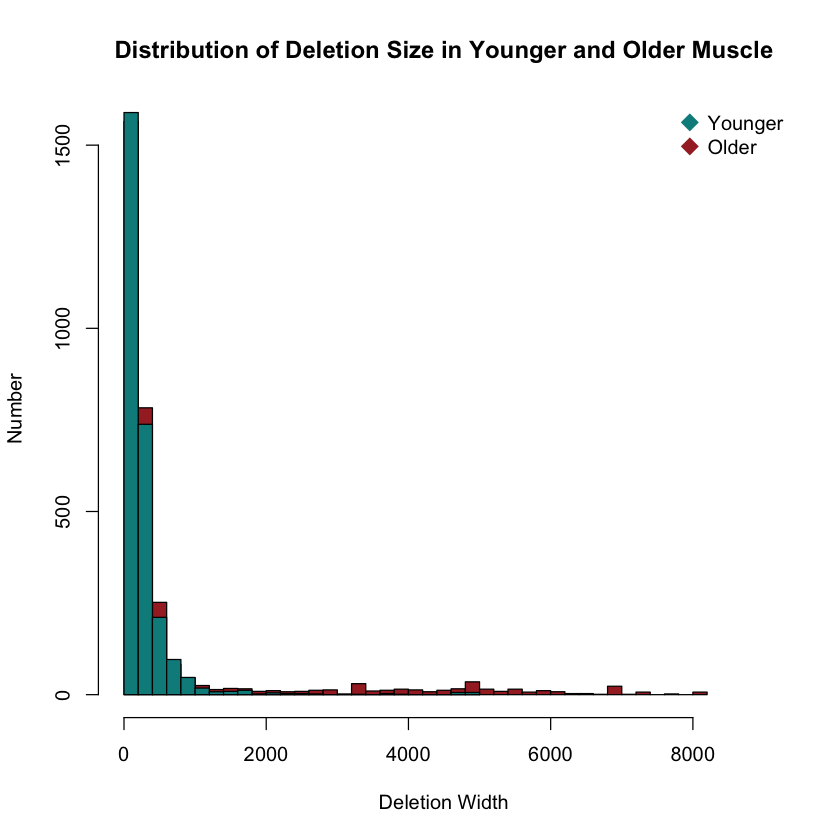

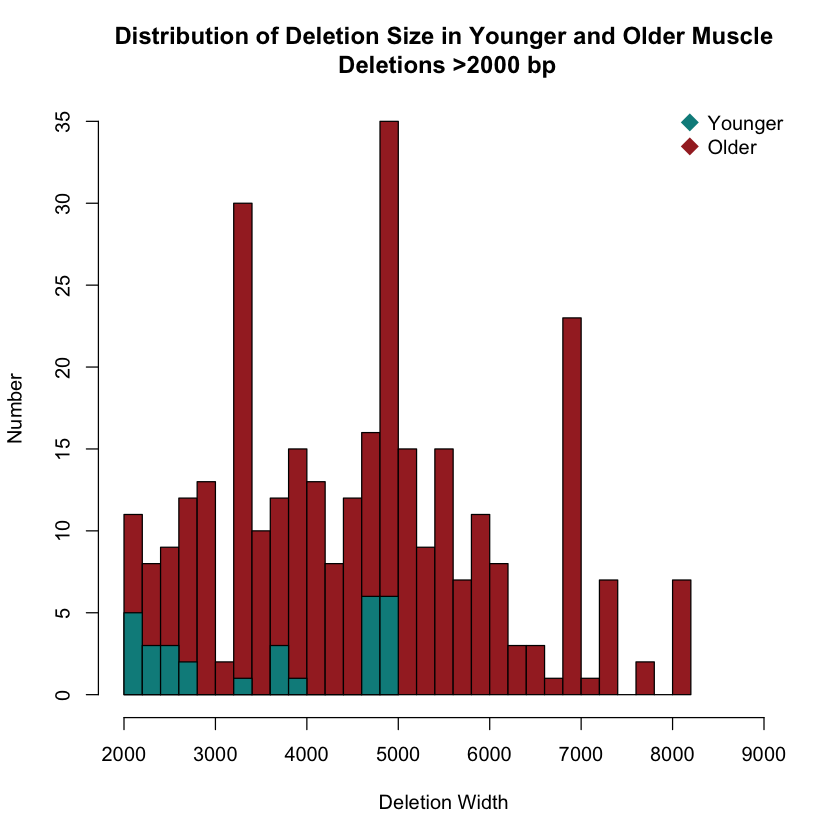

In [109]:
#plot histograms of all deletions and those over 2kbp

#pdf("Muscle/deletions/Del_hist.pdf",height=5,width=5)
hist(Dels$len[which(Dels$cat=="O")],breaks=30,xlim=c(0,9000),col="brown",xlab="Deletion Width",
    ylab="Number",main="Distribution of Deletion Size in Younger and Older Muscle")
hist(Dels$len[which(Dels$cat=="Y")],breaks=30,xlim=c(0,9000),col="cyan4",add=T)
legend("topright", legend=c("Younger","Older"), col=c("cyan4","brown"), pt.cex=2, pch=18,bty="n")
#dev.off()

#pdf("Muscle/deletions/Del_hist_zoom.pdf",height=5,width=5)
hist(Dels1$len[which(Dels1$cat=="O")],breaks=30,xlim=c(2000,9000),col="brown",xlab="Deletion Width",
    ylab="Number",main="Distribution of Deletion Size in Younger and Older Muscle\n Deletions >2000 bp")
hist(Dels1$len[which(Dels1$cat=="Y")],breaks=20,xlim=c(2000,9000),col="cyan4",add=T)
legend("topright", legend=c("Younger","Older"), col=c("cyan4","brown"), pt.cex=2, pch=18,bty="n")

#dev.off()




In [110]:
#un-rotate deletion locations to correspond to actual mito genome, 

Dels$start[which(Dels$start > 15022)]=Dels$start[which(Dels$start > 15022)]-15022
Dels$start[which(Dels$start < 15022)]=Dels$start[which(Dels$start < 15022)]+1547

Dels$end[which(Dels$end > 15022)]=Dels$end[which(Dels$end > 15022)]-15022
Dels$end[which(Dels$end < 15022)]=Dels$end[which(Dels$end < 15022)]+1547


In [111]:
#make bed file of all deletions
Dels$chrom=rep("chrM",nrow(Dels))
bed <- Dels[,c('chrom','start', 'end', 'sample')]
head(bed)
write.table(bed, "Muscle/deletions/Deletion_locations.bed")

,chrom,start,end,sample
,<chr>,<dbl>,<dbl>,<chr>
2,chrM,2148,2295,Y1
3,chrM,1836,1970,Y1
4,chrM,5369,6845,Y1
5,chrM,6879,6995,Y1
6,chrM,12404,12534,Y1
7,chrM,7903,8056,Y1


In [112]:
#filter to include only long ones for plots
Dels=Dels[which(Dels$len>2000),]

In [113]:
#load files of other deletion breakpoints to compare 
other=read.csv("/Users/amyvandiver/Box/Nanopore/Wanagat_Muscle/dels_mitomap.csv")
other1=read.csv("/Users/amyvandiver/Box/Nanopore/Wanagat_Muscle/mitobreak.csv")

In [114]:
#Make big list of all break points, where they came from
mapbreaks=as.numeric(c(unlist(tstrsplit(other$Junction,":")[1]),unlist(tstrsplit(other$Junction,":")[2])))
breakbreaks=c(other1[,2],other1[,3])
delbreaks=c(Dels$start,Dels$end)
breaks=c(delbreaks,breakbreaks,mapbreaks)
type=c(rep("Del",length(delbreaks)),rep("break",length(breakbreaks)),rep("map",length(mapbreaks)))

In [115]:
library("sm")

In [116]:
summary(breaks)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     24    7775   10984   10818   14500   16599 

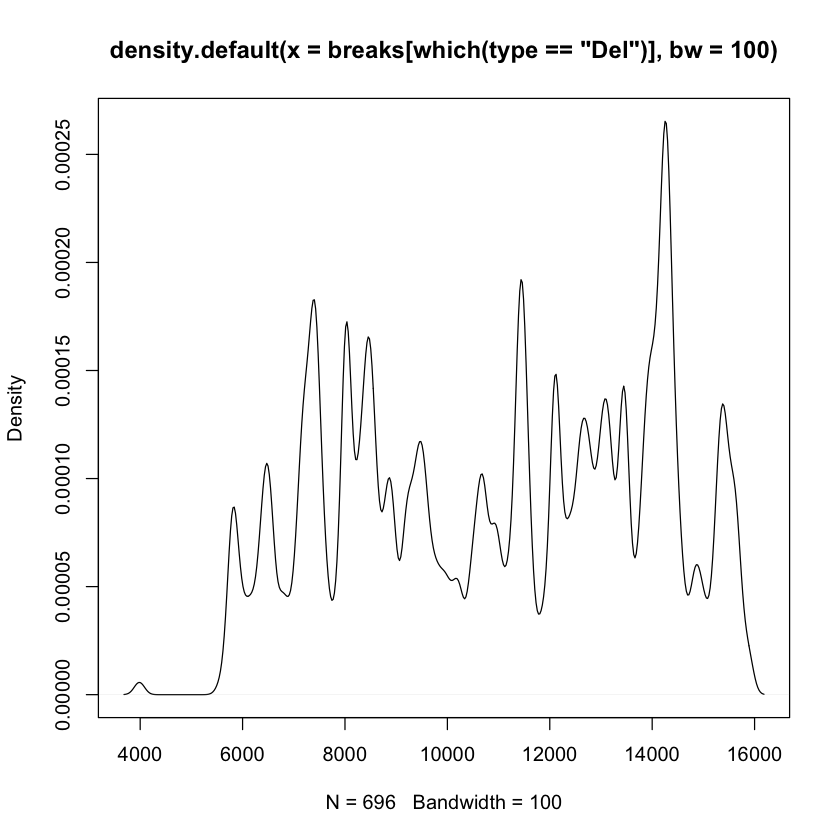

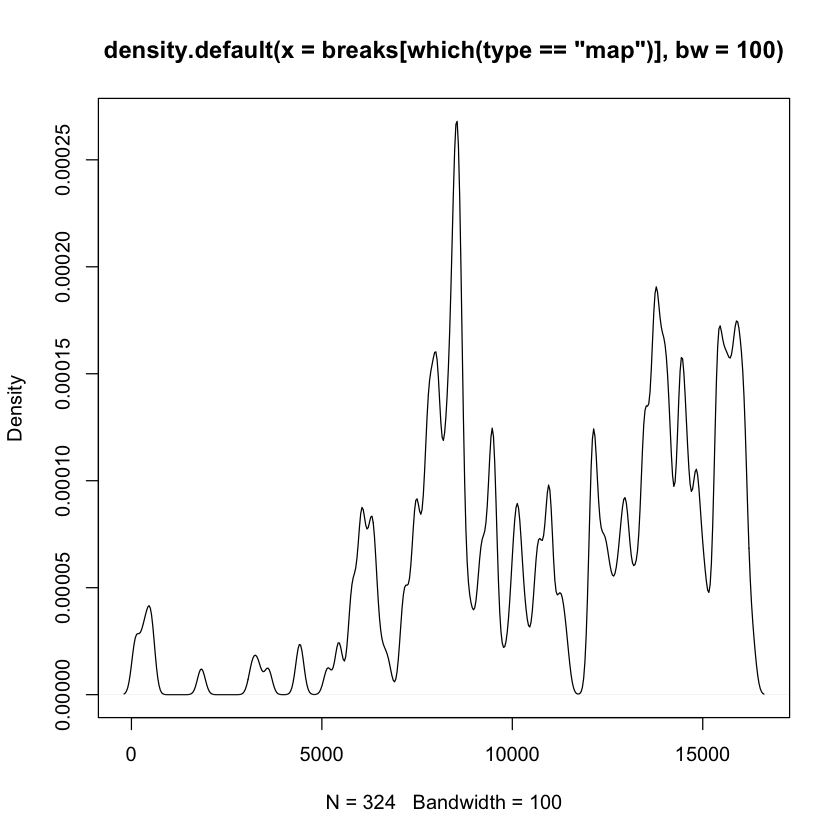

In [131]:
#plot distribution of breakpoints 
plot(density(breaks[which(type=="Del")],bw=100))
plot(density(breaks[which(type=="map")],bw=100))

In [129]:
#use sm to compare the distributions of these deletions to mitomap breakpoitns
pdf("Breakpoint_densitycompare.pdf")
sm.density.compare(breaks[which(type%in%c("Del","map"))],type[which(type%in%c("Del","map"))],model="equal",h=50, xlab="Location on ChrM",ylab="Density of Breakpoints",xlim=c(-500,16800))
dev.off()

Test of equal densities:  p-value =  0.93 


pdf 
  2

In [127]:
#format the annotation file for plotting
locs$col=as.numeric(as.factor(locs$Type))+1
type=as.factor(type)

In [51]:
#make GRanges of Deletions for plotting 
gr_Dels= GRanges(seqnames=rep("M",nrow(Dels)), IRanges(start=Dels$start,end=Dels$start),size=Dels$len)
gr_Dels$to.gr=GRanges(seqnames=rep("M",nrow(Dels)), IRanges(start=Dels$end,end=Dels$end))
gr_Dels$sample=Dels$sample
seqlengths(gr_Dels)<-("M"=16569)
seqlengths(gr_Dels)
seqlevels(gr_Dels)
seqlengths(gr_Dels$to.gr)<-("M"=max(end(gr)))

M 
16569

[1] "M"

In [52]:
#check to make sure right number sof deletions in GRanges
gr_Dels_1=gr_Dels[which(gr_Dels$size>2000)]
summary(as.factor(gr_Dels_1$sample))

O1  O2  O3  Y1  Y2  Y3 
129  89 100   4  19   7

In [53]:
#identify common deletion calls, tag these with red color 
gr_Dels_1$col=rep("black",length(gr_Dels_1))
gr_Dels_1$col[which(start(gr_Dels_1)>8460 & start(gr_Dels_1) <8480 & gr_Dels_1$size<5000)]="red"
length(which(start(gr_Dels_1)>8460 & start(gr_Dels_1) <8480 & gr_Dels_1$size<5000))
gr_Dels_1[which(start(gr_Dels_1)>8460 & start(gr_Dels_1) <8480 & gr_Dels_1$size<5000)]$size


[1] 13

[1] 4977 4977 4979 4976 4977 4978 4977 4977 4979 4977 4977 4977 4978

Warning message in recycleSingleBracketReplacementValue(value, x, nsbs):
"number of values supplied is not a sub-multiple of the number of values to be replaced"
Warning message in recycleSingleBracketReplacementValue(value, x, nsbs):
"number of values supplied is not a sub-multiple of the number of values to be replaced"


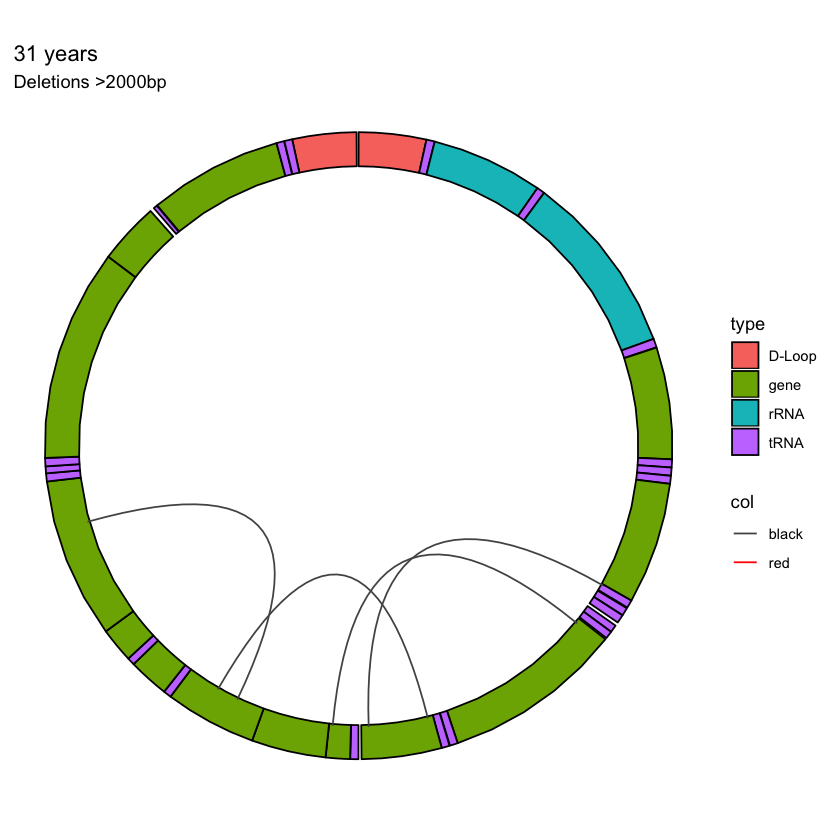

Warning message in recycleSingleBracketReplacementValue(value, x, nsbs):
"number of values supplied is not a sub-multiple of the number of values to be replaced"


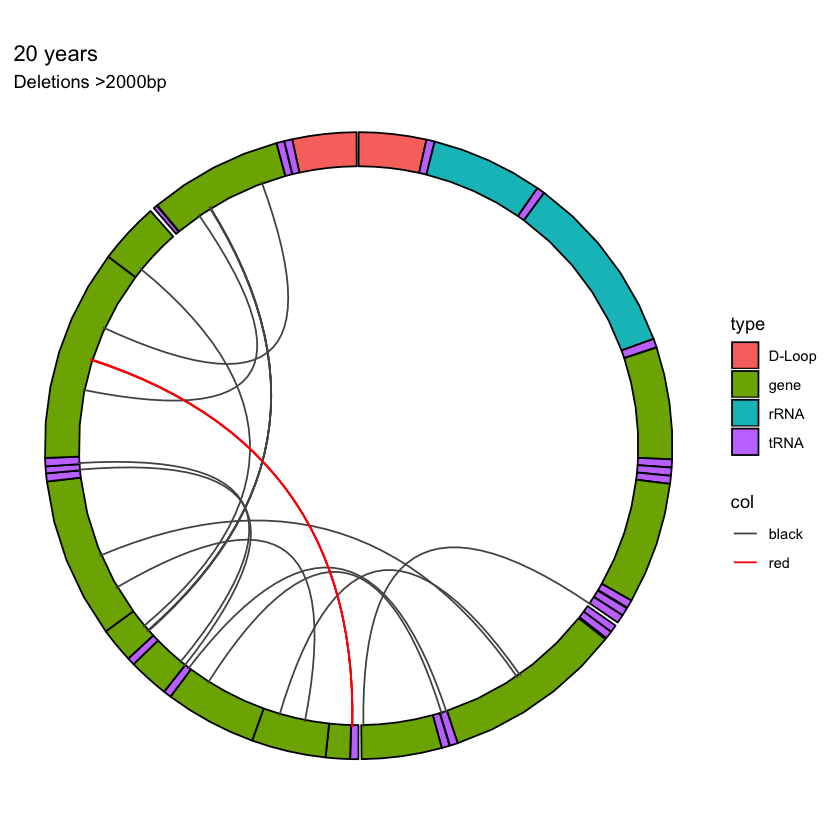

Warning message in recycleSingleBracketReplacementValue(value, x, nsbs):
"number of values supplied is not a sub-multiple of the number of values to be replaced"


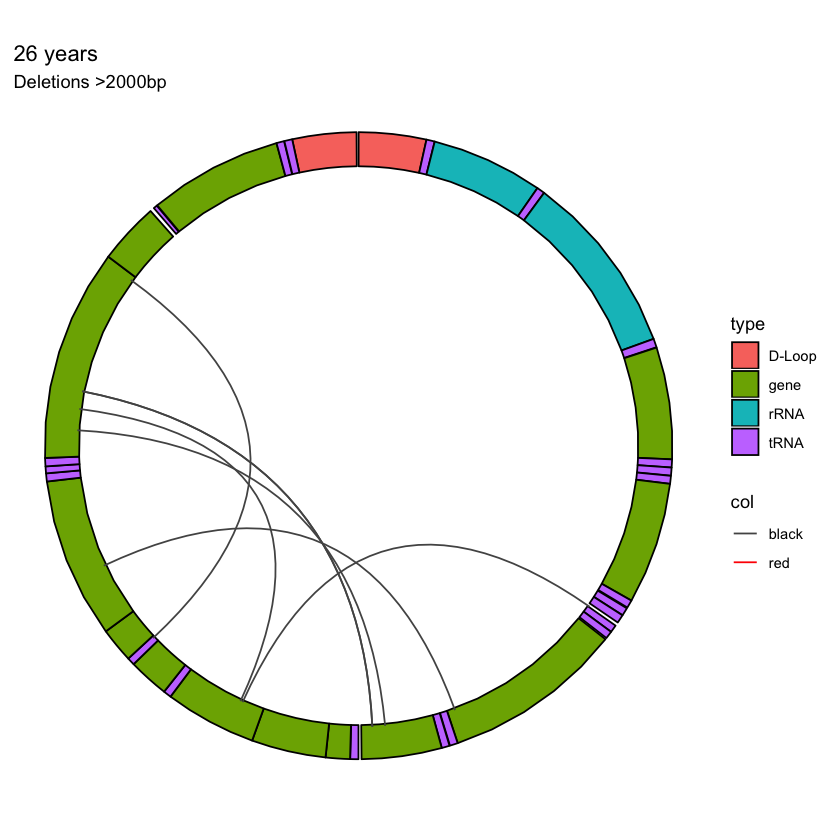

Warning message in recycleSingleBracketReplacementValue(value, x, nsbs):
"number of values supplied is not a sub-multiple of the number of values to be replaced"


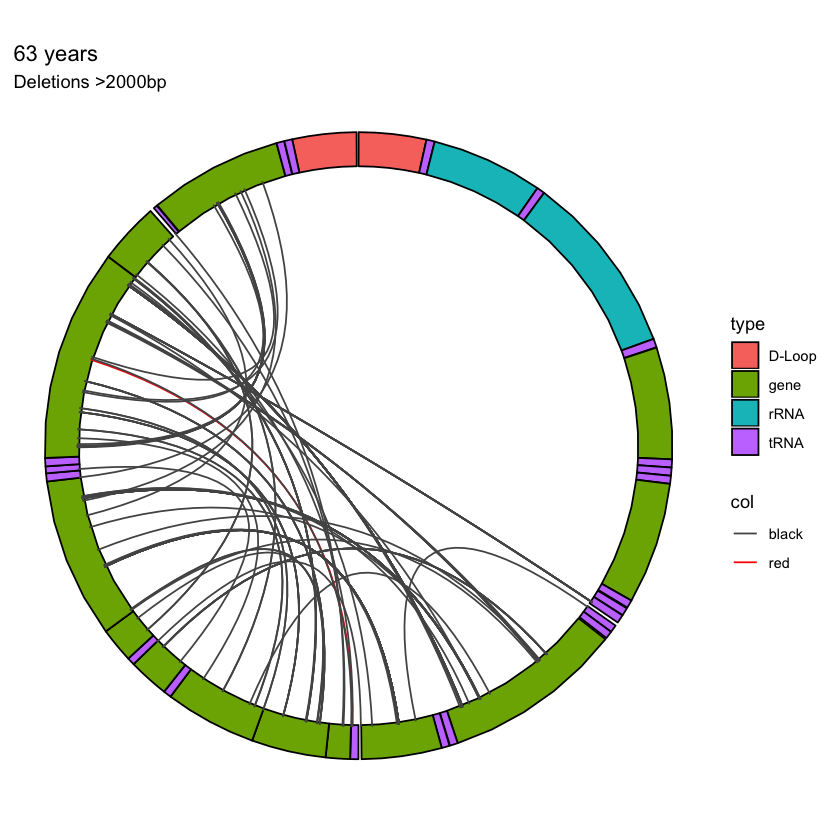

Warning message in recycleSingleBracketReplacementValue(value, x, nsbs):
"number of values supplied is not a sub-multiple of the number of values to be replaced"


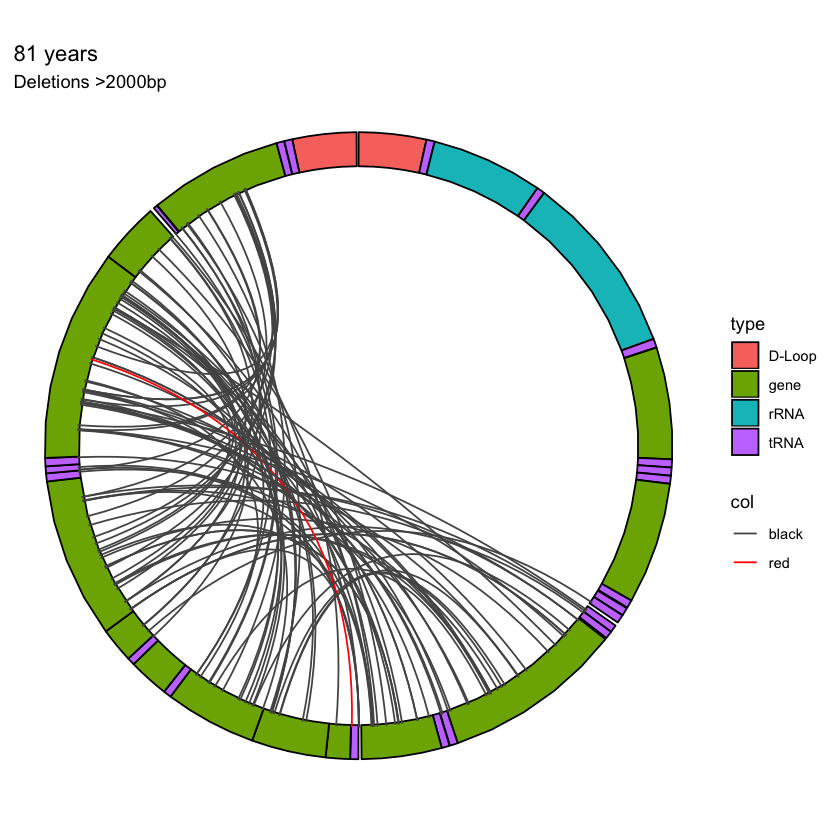

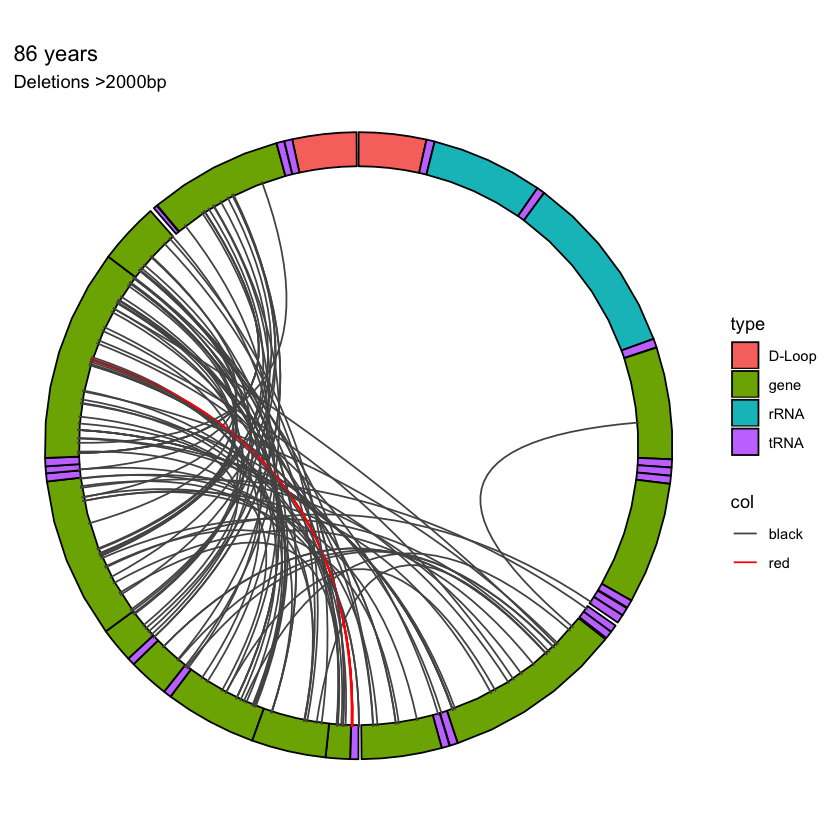

In [55]:
#Plot in circular plot for each sample 
cols <- c("grey33", "red")
names(cols) <- c("black", "red")

Y1= ggbio() + circle(gr,geom='rect',aes(fill=type),space.skip=0.001)+ 
#circle(gr, geom="text", aes(label=names1),radius=42, labels.size=0.2)+
circle(gr_Dels_1[which(gr_Dels_1$sample=="Y1")],geom = "link",aes(color=col), linked.to ="to.gr",radius=35,aes(alpha=0.1)) + 
scale_color_manual(values=cols) +
labs(title="31 years",subtitle="Deletions >2000bp")
Y1

Y2= ggbio() + circle(gr,geom='rect',aes(fill=type),space.skip=0.001)+ 
#circle(gr, geom="text", aes(label=names1),radius=42, labels.size=1)+
circle(gr_Dels_1[which(gr_Dels_1$sample=="Y2")],geom = "link", aes(color=col), linked.to ="to.gr",radius=35,aes(alpha=0.1)) + 
scale_color_manual(values=cols) +
labs(title="20 years",subtitle="Deletions >2000bp")
Y2

Y3= ggbio() + circle(gr,geom='rect',aes(fill=type),space.skip=0.001)+ 
#circle(gr, geom="text", aes(label=names1),radius=42, labels.size=1)+
circle(gr_Dels_1[which(gr_Dels_1$sample=="Y3")],geom = "link",aes(color=col), linked.to ="to.gr",radius=35,aes(alpha=0.1)) + 
scale_color_manual(values=cols) +
labs(title="26 years",subtitle="Deletions >2000bp")
Y3

O1= ggbio() + circle(gr,geom='rect',aes(fill=type),space.skip=0.001)+ 
#circle(gr, geom="text", aes(label=names1),radius=42, labels.size=1)+
circle(gr_Dels_1[which(gr_Dels_1$sample=="O1")],geom = "link", aes(color=col),linked.to ="to.gr",radius=35,aes(alpha=0.1)) + 
scale_color_manual(values=cols) +
labs(title="63 years",subtitle="Deletions >2000bp")
O1

O2= ggbio() + circle(gr,geom='rect',aes(fill=type),space.skip=0.001)+ 
#circle(gr, geom="text", aes(label=names1),radius=42, labels.size=1)+
circle(gr_Dels_1[which(gr_Dels_1$sample=="O2")],geom = "link", aes(color=col),linked.to ="to.gr",radius=35,aes(alpha=0.1)) + 
scale_color_manual(values=cols) +
labs(title="81 years",subtitle="Deletions >2000bp")
O2


O3= ggbio() + circle(gr,geom='rect',aes(fill=type),space.skip=0.001)+ 
#circle(gr, geom="text", aes(label=names1),radius=42, labels.size=1)+
circle(gr_Dels_1[which(gr_Dels_1$sample=="O3")],geom = "link",aes(color=col), linked.to ="to.gr",radius=35,aes(alpha=0.1)) + 
scale_color_manual(values=cols) +
labs(title="86 years",subtitle="Deletions >2000bp")
O3

In [59]:
pdf("Muscle/deletions/Del_plots_combined.pdf",width=12,height=8)
arrangeGrobByParsingLegend(Y2,Y3,Y1,O1,O2,O3,nrow = 2, ncol = 3, legend.idx = 1)
dev.off()






,X,sample,read,start,len,cat,end,chrom
,<int>,<chr>,<chr>,<dbl>,<int>,<chr>,<dbl>,<chr>
135,135,Y1,82fd1fd4-509b-4916-afee-f364c01efe21,9602,2279,Y,11881,chrM
159,159,Y1,ad9d96e3-3a91-44c0-807d-61ebbcc66195,7744,2067,Y,9811,chrM
190,190,Y1,f78252bf-e434-40f2-832a-bb0e291672fb,6034,2623,Y,8657,chrM
282,282,Y1,a4faf077-3bc0-4fbd-9524-a34629fe2cf4,5597,2717,Y,8314,chrM
457,457,Y2,b2d4ae73-ebf2-4019-a0d1-41bca035eeaa,7605,2319,Y,9924,chrM
724,724,Y2,dd5c36f0-4e6e-4fca-80d5-721fecd261d0,5812,2552,Y,8364,chrM


In [1]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS  10.16

Matrix products: default
BLAS/LAPACK: /Users/amyvandiver/opt/anaconda3/envs/r_env/lib/libopenblasp-r0.3.12.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_1.0.2     utf8_1.2.2      digest_0.6.29   crayon_1.5.0   
 [5] IRdisplay_1.1   repr_1.1.4      lifecycle_1.0.1 jsonlite_1.8.0 
 [9] evaluate_0.15   pillar_1.7.0    rlang_1.0.1     cli_3.2.0      
[13] uuid_1.0-3      vctrs_0.3.8     ellipsis_0.3.2  IRkernel_1.3   
[17] tools_4.0.2     glue_1.6.1      fastmap_1.1.0   compiler_4.0.2 
[21] base64enc_0.1-3 pbdZMQ_0.3-7    htmltools_0.5.2